In [1]:
import numpy as np
import awkward as ak
import uproot
import vector
vector.register_awkward()
import os
import shutil
import zipfile
import tarfile
import urllib
import requests
from tqdm import tqdm

In [13]:
example_file = '/home/sandeep/Desktop/qcdout.root'
tree = uproot.open(example_file)['tree']
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
part_px              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_py              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_pz              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_energy          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_deta            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dphi            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_d0val           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_d0err           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dzval           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dzerr           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_charge          | std::

In [6]:
table = tree.arrays()
table

<Array [{part_px: [...], ...}, ..., {...}] type='16780 * {part_px: var * fl...'>

In [7]:
p4 = vector.zip({'px': table['part_px'], 'py': table['part_py'], 'pz': table['part_pz'], 'energy': table['part_energy']})

In [14]:
p4.pt,p4.eta, p4.phi

(<Array [[197, 78.7, 51.4, ..., 1.04, 0.879], ...] type='16780 * var * float32'>,
 <Array [[-1.16, -1.17, ..., -1.24, -0.916], ...] type='16780 * var * float32'>,
 <Array [[3.02, 3.03, 3, ..., 2.98, -3.07], ...] type='16780 * var * float32'>)

In [11]:
def _pad(a, maxlen, value=0, dtype='float32'):
    if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
        return a
    elif isinstance(a, ak.Array):
        if a.ndim == 1:
            a = ak.unflatten(a, 1)
        a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
        return ak.values_astype(a, dtype)
    else:
        x = (np.ones((len(a), maxlen)) * value).astype(dtype)
        for idx, s in enumerate(a):
            if not len(s):
                continue
            trunc = s[:maxlen].astype(dtype)
            x[idx, :len(trunc)] = trunc
        return x


In [12]:
_pad(p4.pt, maxlen=128).to_numpy()

array([[ 196.50806 ,   78.735756,   51.42866 , ...,    0.      ,
           0.      ,    0.      ],
       [ 181.08533 ,   68.162224,   62.62913 , ...,    0.      ,
           0.      ,    0.      ],
       [  62.262928,   42.378605,   36.037212, ...,    0.      ,
           0.      ,    0.      ],
       ...,
       [1132.1057  , 1025.6813  ,  170.90335 , ...,    0.      ,
           0.      ,    0.      ],
       [1752.1206  ,  333.51627 ,  294.78622 , ...,    0.      ,
           0.      ,    0.      ],
       [2039.0775  ,  211.3566  ,   83.66423 , ...,    0.      ,
           0.      ,    0.      ]], dtype=float32)

In [17]:
import uproot
import awkward as ak
import numpy as np

# -----------------------------
# Input / Output
# -----------------------------
qcd_file   = "/home/sandeep/Desktop/qcdout.root"
higgs_file = "/home/sandeep/Desktop/higgsout.root"
out_file   = "/home/sandeep/Desktop/combined_qcd_higgs.root"

tree_name = "tree"

# -----------------------------
# Read QCD
# -----------------------------
with uproot.open(qcd_file) as f:
    qcd = f[tree_name].arrays(library="ak")

qcd = ak.with_field(
    qcd,
    np.zeros(len(qcd), dtype=np.int32),
    "class_id"
)

# -----------------------------
# Read Higgs
# -----------------------------
with uproot.open(higgs_file) as f:
    higgs = f[tree_name].arrays(library="ak")

higgs = ak.with_field(
    higgs,
    np.ones(len(higgs), dtype=np.int32),
    "class_id"
)

# -----------------------------
# Combine
# -----------------------------
combined = ak.concatenate([qcd, higgs])

# -----------------------------
# Write ROOT file (IMPORTANT PART)
# -----------------------------
with uproot.recreate(out_file) as f:
    f[tree_name] = {field: combined[field] for field in combined.fields}

print("✔ Successfully written:")
print(out_file)


✔ Successfully written:
/home/sandeep/Desktop/combined_qcd_higgs.root


In [26]:
with uproot.open(out_file) as f:
    tree = f[tree_name]
    tree.show()

    labels = tree["class_id"].array()
    print(np.unique(labels, return_counts=True))


name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
npart_px             | int32_t                  | AsDtype('>i4')
part_px              | float[]                  | AsJagged(AsDtype('>f4'))
npart_py             | int32_t                  | AsDtype('>i4')
part_py              | float[]                  | AsJagged(AsDtype('>f4'))
npart_pz             | int32_t                  | AsDtype('>i4')
part_pz              | float[]                  | AsJagged(AsDtype('>f4'))
npart_energy         | int32_t                  | AsDtype('>i4')
part_energy          | float[]                  | AsJagged(AsDtype('>f4'))
npart_deta           | int32_t                  | AsDtype('>i4')
part_deta            | float[]                  | AsJagged(AsDtype('>f4'))
npart_dphi           | int32_t                  | AsDtype('>i4')
part_dphi            | float[]                  | AsJagged(AsDtype('>f4')

In [34]:
def build_features_and_labels(
    root_file,
    tree_name="tree",
    maxlen=128,
    transform_features=True
):
    import uproot
    import awkward as ak
    import numpy as np

    # -----------------------------
    # OPEN FILE AND LOAD ARRAYS
    # -----------------------------
    with uproot.open(root_file) as f:
        tree = f[tree_name]

        a = tree.arrays(
            filter_name=[
                "part_*",
                "jet_pt",
                "jet_energy",
                "class_id"
            ],
            library="ak"
        )

    # ⬆️⬆️⬆️ FILE IS CLOSED HERE — BUT DATA IS NOW LOADED ⬆️⬆️⬆️
    # NO MORE tree.arrays() CALLS AFTER THIS POINT

    # -----------------------------
    # Particle mask
    # -----------------------------
    a["part_mask"] = ak.ones_like(a["part_energy"])

    # -----------------------------
    # Derived kinematics
    # -----------------------------
    a["part_pt"] = np.hypot(a["part_px"], a["part_py"])
    a["part_pt_log"] = np.log(a["part_pt"] + 1e-6)
    a["part_e_log"] = np.log(a["part_energy"] + 1e-6)

    a["part_logptrel"] = np.log((a["part_pt"] + 1e-6) / (a["jet_pt"] + 1e-6))
    a["part_logerel"] = np.log((a["part_energy"] + 1e-6) / (a["jet_energy"] + 1e-6))

    a["part_deltaR"] = np.hypot(a["part_deta"], a["part_dphi"])
    a["part_d0"] = np.tanh(a["part_d0val"])
    a["part_dz"] = np.tanh(a["part_dzval"])

    if transform_features:
        a["part_pt_log"]   = (a["part_pt_log"] - 1.7) * 0.7
        a["part_e_log"]    = (a["part_e_log"] - 2.0) * 0.7
        a["part_logptrel"] = (a["part_logptrel"] + 4.7) * 0.7
        a["part_logerel"]  = (a["part_logerel"] + 4.7) * 0.7
        a["part_deltaR"]   = (a["part_deltaR"] - 0.2) * 4.0
        a["part_d0err"]    = _clip(a["part_d0err"], 0, 1)
        a["part_dzerr"]    = _clip(a["part_dzerr"], 0, 1)

    feature_list = {
        "pf_features": [
            "part_pt_log",
            "part_e_log",
            "part_logptrel",
            "part_logerel",
            "part_deltaR",
            "part_charge",
            "part_isChargedHadron",
            "part_isNeutralHadron",
            "part_isPhoton",
            "part_isElectron",
            "part_isMuon",
            "part_d0",
            "part_d0err",
            "part_dz",
            "part_dzerr",
            "part_deta",
            "part_dphi",
        ],
        "pf_vectors": [
            "part_px",
            "part_py",
            "part_pz",
            "part_energy",
        ],
        "pf_mask": ["part_mask"],
    }

    out = {}
    for key, names in feature_list.items():
        out[key] = np.stack(
            [_pad(a[n], maxlen=maxlen).to_numpy() for n in names],
            axis=1
        )

    out["label"] = a["class_id"].to_numpy().astype(np.int64)

    return out


In [32]:
def _clip(a, a_min, a_max):
    try:
        return np.clip(a, a_min, a_max)
    except ValueError:
        return ak.unflatten(np.clip(ak.flatten(a), a_min, a_max), ak.num(a))

In [35]:
out = build_features_and_labels(
    "/home/sandeep/Desktop/combined_qcd_higgs.root"
)


In [36]:
for k, v in out.items():
    print(k, type(v), v.shape)

pf_features <class 'numpy.ndarray'> (37870, 17, 128)
pf_vectors <class 'numpy.ndarray'> (37870, 4, 128)
pf_mask <class 'numpy.ndarray'> (37870, 1, 128)
label <class 'numpy.ndarray'> (37870,)


In [37]:
print("Mask values:", np.unique(out["pf_mask"]))
print("Label counts:", np.unique(out["label"], return_counts=True))


Mask values: [0. 1.]
Label counts: (array([0, 1]), array([16780, 21090]))


In [38]:
def _pad(a, maxlen, value=0, dtype="float32"):
    """
    Pads or truncates a jagged Awkward array to fixed length.
    Output shape: (N, maxlen)
    """
    if isinstance(a, ak.Array):
        a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
        return ak.values_astype(a, dtype)
    else:
        out = np.full((len(a), maxlen), value, dtype=dtype)
        for i, row in enumerate(a):
            if len(row) == 0:
                continue
            trunc = row[:maxlen].astype(dtype)
            out[i, :len(trunc)] = trunc
        return out


# --------------------------------------------------
# Main reader (Particle Transformer compatible)
# --------------------------------------------------
def read_file(
    filepath,
    tree_name="tree",
    max_num_particles=128,
    particle_features=(
        "part_pt",
        "part_eta",
        "part_phi",
        "part_energy",
        "part_charge",
        "part_isChargedHadron",
        "part_isNeutralHadron",
        "part_isPhoton",
        "part_isElectron",
        "part_isMuon",
    ),
    jet_features=(
        "jet_pt",
        "jet_eta",
        "jet_phi",
        "jet_energy",
    ),
    label_name="class_id",   # binary or multi-class
):
    """
    Loads a ROOT file and returns Particle Transformer–ready tensors.

    Returns
    -------
    x_particles : np.ndarray
        Shape (N_jets, N_particle_features, max_num_particles)

    x_jets : np.ndarray
        Shape (N_jets, N_jet_features)

    y : np.ndarray
        Shape (N_jets,)
    """

    # -----------------------------
    # Load ROOT arrays
    # -----------------------------
    with uproot.open(filepath) as f:
        tree = f[tree_name]
        table = tree.arrays(library="ak")

    # -----------------------------
    # Build particle 4-vectors
    # -----------------------------
    p4 = vector.zip(
        {
            "px": table["part_px"],
            "py": table["part_py"],
            "pz": table["part_pz"],
            "energy": table["part_energy"],
        }
    )

    table["part_pt"] = p4.pt
    table["part_eta"] = p4.eta
    table["part_phi"] = p4.phi

    # -----------------------------
    # Particle tensor
    # -----------------------------
    x_particles = np.stack(
        [
            ak.to_numpy(_pad(table[name], max_num_particles))
            for name in particle_features
        ],
        axis=1,   # (N, features, particles)
    ).astype("float32")

    # -----------------------------
    # Jet-level tensor
    # -----------------------------
    x_jets = np.stack(
        [ak.to_numpy(table[name]).astype("float32") for name in jet_features],
        axis=1,
    )

    # -----------------------------
    # Labels
    # -----------------------------
    y = ak.to_numpy(table[label_name]).astype("int64")

    return x_particles, x_jets, y


In [43]:
x_particles, x_jets, y = read_file(
    "/home/sandeep/Desktop/combined_qcd_higgs.root"
)

print("x_particles:", x_particles.shape)
print("x_jets:", x_jets.shape)
print("labels:", np.unique(y, return_counts=True))


x_particles: (37870, 10, 128)
x_jets: (37870, 4)
labels: (array([0, 1]), array([16780, 21090]))


In [44]:
import numpy as np
from sklearn.model_selection import train_test_split

X_p_train, X_p_val, X_j_train, X_j_val, y_train, y_val = train_test_split(
    x_particles, x_jets, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class JetDataset(Dataset):
    def __init__(self, xp, xj, y):
        self.xp = torch.tensor(xp, dtype=torch.float32)
        self.xj = torch.tensor(xj, dtype=torch.float32)
        self.y  = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.xp[idx], self.xj[idx], self.y[idx]

train_ds = JetDataset(X_p_train, X_j_train, y_train)
val_ds   = JetDataset(X_p_val,   X_j_val,   y_val)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)


In [52]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleParticleTransformer(nn.Module):
    def __init__(self, n_feat, n_heads=4, dim=64):
        super().__init__()

        self.embed = nn.Linear(n_feat, dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim,
            nhead=n_heads,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

        self.classifier = nn.Sequential(
            nn.Linear(dim, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x_particles):
        # x_particles: (B, C, P) → (B, P, C)
        x = x_particles.permute(0, 2, 1)

        x = self.embed(x)              # (B, P, dim)
        x = self.encoder(x)            # (B, P, dim)
        x = x.mean(dim=1)              # global pooling

        return self.classifier(x)
# class SimpleParticleTransformer(nn.Module):
#     def __init__(self, n_feat, n_jet, dim=64):
#         super().__init__()

#         self.embed = nn.Linear(n_feat, dim)

#         enc = nn.TransformerEncoderLayer(d_model=dim, nhead=4, batch_first=True)
#         self.encoder = nn.TransformerEncoder(enc, num_layers=4)

#         self.classifier = nn.Sequential(
#             nn.Linear(dim + n_jet, 128),
#             nn.ReLU(),
#             nn.Linear(128, 2)
#         )

#     def forward(self, x_particles, x_jets):
#         x = x_particles.permute(0, 2, 1)
#         x = self.embed(x)
#         x = self.encoder(x)
#         x = x.mean(dim=1)

#         x = torch.cat([x, x_jets], dim=1)
#         return self.classifier(x)


In [53]:
from sklearn.metrics import roc_auc_score

device = "cuda" if torch.cuda.is_available() else "cpu"

model = SimpleParticleTransformer(n_feat=x_particles.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train_epoch(loader):
    model.train()
    total_loss = 0
    for xp, _, y in loader:
        xp, y = xp.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(xp)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(y)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def eval_epoch(loader):
    model.eval()
    probs, labels = [], []

    for xp, _, y in loader:
        xp = xp.to(device)
        logits = model(xp)
        p = torch.softmax(logits, dim=1)[:,1]

        probs.append(p.cpu())
        labels.append(y)

    probs = torch.cat(probs).numpy()
    labels = torch.cat(labels).numpy()

    auc = roc_auc_score(labels, probs)
    return auc, probs, labels


In [48]:
for epoch in range(1, 11):
    loss = train_epoch(train_loader)
    auc, _, _ = eval_epoch(val_loader)

    print(f"Epoch {epoch:02d} | loss={loss:.4f} | val AUC={auc:.4f}")


Epoch 01 | loss=0.6244 | val AUC=0.6659
Epoch 02 | loss=0.6713 | val AUC=0.6653
Epoch 03 | loss=0.6428 | val AUC=0.6644
Epoch 04 | loss=0.6096 | val AUC=0.6644
Epoch 05 | loss=0.6068 | val AUC=0.6644
Epoch 06 | loss=0.6068 | val AUC=0.6645
Epoch 07 | loss=0.6298 | val AUC=0.5615
Epoch 08 | loss=0.6855 | val AUC=0.5925
Epoch 09 | loss=0.6830 | val AUC=0.6459
Epoch 10 | loss=0.6834 | val AUC=0.6145


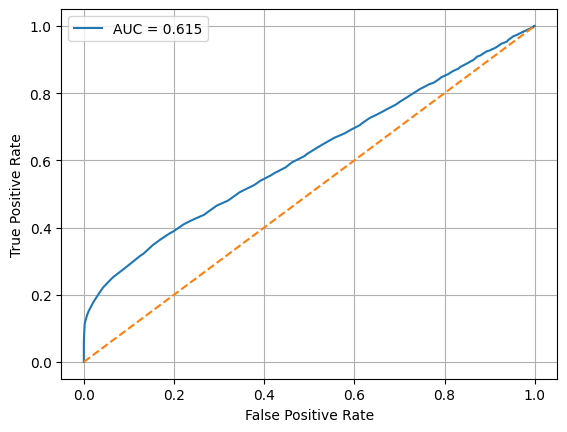

In [49]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

auc, probs, labels = eval_epoch(val_loader)

fpr, tpr, _ = roc_curve(labels, probs)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


In [54]:
import numpy as np
from sklearn.model_selection import train_test_split

X_p_train, X_p_val, X_j_train, X_j_val, y_train, y_val = train_test_split(
    x_particles, x_jets, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [55]:
import torch
from torch.utils.data import Dataset, DataLoader

class JetDatasetPT(Dataset):
    def __init__(self, xp, xj, y):
        self.xp = torch.tensor(xp, dtype=torch.float32)
        self.xj = torch.tensor(xj, dtype=torch.float32)
        self.y  = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.xp[idx], self.xj[idx], self.y[idx]

train_loader_pt = DataLoader(
    JetDatasetPT(X_p_train, X_j_train, y_train),
    batch_size=64, shuffle=True
)

val_loader_pt = DataLoader(
    JetDatasetPT(X_p_val, X_j_val, y_val),
    batch_size=256, shuffle=False
)


In [56]:
import torch.nn as nn

class SimpleParticleTransformer(nn.Module):
    def __init__(self, n_part_feat, n_jet_feat, dim=64, heads=4, layers=3):
        super().__init__()

        self.embed = nn.Linear(n_part_feat, dim)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=dim,
            nhead=heads,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=layers)

        self.classifier = nn.Sequential(
            nn.Linear(dim + n_jet_feat, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x_particles, x_jets):
        # (B, C, P) → (B, P, C)
        x = x_particles.permute(0, 2, 1)
        x = self.embed(x)
        x = self.encoder(x)
        x = x.mean(dim=1)  # global pooling

        x = torch.cat([x, x_jets], dim=1)
        return self.classifier(x)


In [81]:
from sklearn.metrics import roc_auc_score

device = "cuda" if torch.cuda.is_available() else "cpu"

model_pt = SimpleParticleTransformer(
    n_part_feat=x_particles.shape[1],
    n_jet_feat=x_jets.shape[1]
).to(device)

optimizer = torch.optim.Adam(model_pt.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train_epoch_pt():
    model_pt.train()
    for xp, xj, yb in train_loader_pt:
        xp, xj, yb = xp.to(device), xj.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model_pt(xp, xj), yb)
        loss.backward()
        optimizer.step()
    print(f"PT Epoch {epoch:02d} | loss = {loss:.4f}")


@torch.no_grad()
def eval_pt():
    model_pt.eval()
    probs, labels = [], []
    for xp, xj, yb in val_loader_pt:
        xp, xj = xp.to(device), xj.to(device)
        p = torch.softmax(model_pt(xp, xj), dim=1)[:,1]
        probs.append(p.cpu())
        labels.append(yb)
    return (
        torch.cat(probs).numpy(),
        torch.cat(labels).numpy()
    )

for epoch in range(15):
    train_epoch_pt()


PT Epoch 00 | loss = 0.5399
PT Epoch 01 | loss = 0.9391
PT Epoch 02 | loss = 0.7634
PT Epoch 03 | loss = 0.5373
PT Epoch 04 | loss = 0.8196
PT Epoch 05 | loss = 0.7396
PT Epoch 06 | loss = 0.5257
PT Epoch 07 | loss = 0.5953
PT Epoch 08 | loss = 0.5442
PT Epoch 09 | loss = 0.4647
PT Epoch 10 | loss = 0.6349
PT Epoch 11 | loss = 0.6921
PT Epoch 12 | loss = 0.9775
PT Epoch 13 | loss = 0.8302
PT Epoch 14 | loss = 0.8909


In [82]:
probs_pt, labels_val = eval_pt()


In [59]:
from torch_geometric.data import Data

def build_graph_dataset(x_particles, x_jets, y, dr_cut=0.4):
    graphs = []
    for i in range(len(y)):
        xp = x_particles[i]  # (C, P)
        mask = xp[0] != 0
        xp = xp[:, mask].T   # (N, C)

        eta = xp[:, 1]
        phi = xp[:, 2]

        edges = []
        for m in range(len(xp)):
            for n in range(m+1, len(xp)):
                dr = ((eta[m]-eta[n])**2 + (phi[m]-phi[n])**2)**0.5
                if dr < dr_cut:
                    edges.append([m, n])
                    edges.append([n, m])

        if len(edges) == 0:
            continue

        edge_index = torch.tensor(edges).t().contiguous()

        graphs.append(
            Data(
                x=torch.tensor(xp, dtype=torch.float32),
                edge_index=edge_index,
                y=torch.tensor(y[i], dtype=torch.long)
            )
        )
    return graphs


In [60]:
from torch_geometric.loader import DataLoader as GeoLoader

graphs = build_graph_dataset(X_p_val, X_j_val, y_val)

val_loader_gnn = GeoLoader(graphs, batch_size=64)


In [61]:
from torch_geometric.nn import GCNConv, global_mean_pool

class SimpleGNN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 64)
        self.conv2 = GCNConv(64, 64)
        self.lin = nn.Linear(64, 2)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x, batch)
        return self.lin(x)


In [62]:
@torch.no_grad()
def eval_gnn(model, loader):
    model.eval()
    probs, labels = [], []
    for data in loader:
        data = data.to(device)
        p = torch.softmax(model(data), dim=1)[:,1]
        probs.append(p.cpu())
        labels.append(data.y.cpu())
    return (
        torch.cat(probs).numpy(),
        torch.cat(labels).numpy()
)


In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GeoLoader
from torch_geometric.nn import GCNConv, global_mean_pool


In [65]:
import numpy as np

def build_graph_dataset(x_particles, y, dr_cut=0.4):
    graphs = []

    for i in range(len(y)):
        xp = x_particles[i]          # (C, P)
        mask = xp[0] != 0            # padding mask (pt != 0)
        xp = xp[:, mask].T           # (N_particles, C)

        if xp.shape[0] < 2:
            continue

        eta = xp[:, 1]
        phi = xp[:, 2]

        edges = []
        for m in range(len(xp)):
            for n in range(m + 1, len(xp)):
                dr = np.sqrt((eta[m] - eta[n])**2 + (phi[m] - phi[n])**2)
                if dr < dr_cut:
                    edges.append([m, n])
                    edges.append([n, m])

        if len(edges) == 0:
            continue

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

        graphs.append(
            Data(
                x=torch.tensor(xp, dtype=torch.float32),
                edge_index=edge_index,
                y=torch.tensor(y[i], dtype=torch.long)
            )
        )

    return graphs


In [66]:
graphs_train = build_graph_dataset(X_p_train, y_train)
graphs_val   = build_graph_dataset(X_p_val,   y_val)

train_loader_gnn = GeoLoader(graphs_train, batch_size=64, shuffle=True)
val_loader_gnn   = GeoLoader(graphs_val,   batch_size=256, shuffle=False)


In [67]:
class SimpleGNN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 64)
        self.conv2 = GCNConv(64, 64)
        self.lin   = nn.Linear(64, 2)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = global_mean_pool(x, batch)
        return self.lin(x)


In [68]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_gnn = SimpleGNN(
    in_channels=X_p_train.shape[1]   # number of particle features
).to(device)


In [69]:
optimizer_gnn = torch.optim.Adam(model_gnn.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train_epoch_gnn():
    model_gnn.train()
    total_loss = 0

    for data in train_loader_gnn:
        data = data.to(device)

        optimizer_gnn.zero_grad()
        logits = model_gnn(data)
        loss = criterion(logits, data.y)
        loss.backward()
        optimizer_gnn.step()

        total_loss += loss.item() * data.num_graphs

    return total_loss / len(train_loader_gnn.dataset)


In [75]:
for epoch in range(1, 16):
    loss = train_epoch_gnn()
    print(f"GNN Epoch {epoch:02d} | loss = {loss:.4f}")


GNN Epoch 01 | loss = 0.6179
GNN Epoch 02 | loss = 0.6159
GNN Epoch 03 | loss = 0.6115
GNN Epoch 04 | loss = 0.6085
GNN Epoch 05 | loss = 0.6055
GNN Epoch 06 | loss = 0.6054
GNN Epoch 07 | loss = 0.6019
GNN Epoch 08 | loss = 0.6016
GNN Epoch 09 | loss = 0.6044
GNN Epoch 10 | loss = 0.6017
GNN Epoch 11 | loss = 0.5976
GNN Epoch 12 | loss = 0.5984
GNN Epoch 13 | loss = 0.5979
GNN Epoch 14 | loss = 0.5972
GNN Epoch 15 | loss = 0.5941


In [76]:
@torch.no_grad()
def eval_gnn(model, loader):
    model.eval()
    probs, labels = [], []

    for data in loader:
        data = data.to(device)
        logits = model(data)
        p = torch.softmax(logits, dim=1)[:, 1]

        probs.append(p.cpu())
        labels.append(data.y.cpu())

    return (
        torch.cat(probs).numpy(),
        torch.cat(labels).numpy()
    )


In [77]:
probs_gnn, labels_gnn = eval_gnn(model_gnn, val_loader_gnn)


In [73]:
import numpy as np
assert np.all(labels_gnn == labels_val)


ValueError: operands could not be broadcast together with shapes (7236,) (7574,) 

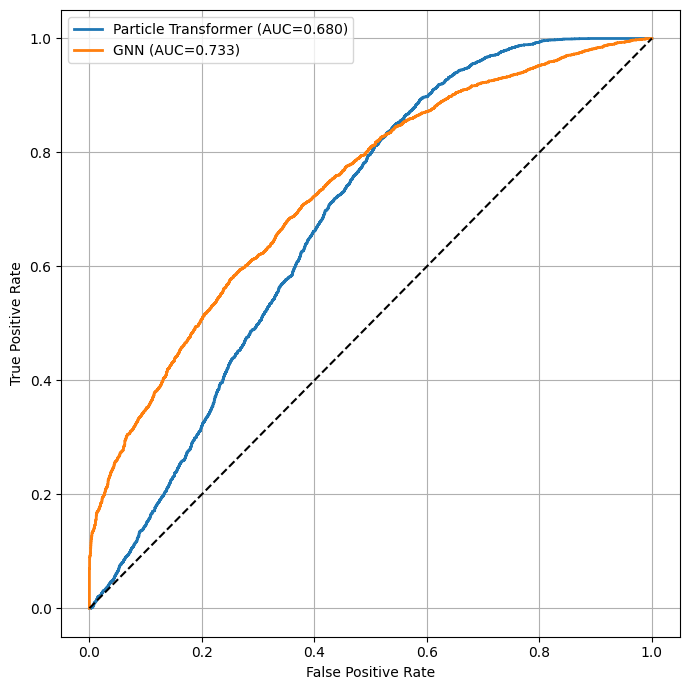

In [83]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr_gnn, tpr_gnn, _ = roc_curve(labels_gnn, probs_gnn)
auc_gnn = roc_auc_score(labels_gnn, probs_gnn)

fpr_pt, tpr_pt, _ = roc_curve(labels_val, probs_pt)
auc_pt = roc_auc_score(labels_val, probs_pt)

plt.figure(figsize=(7,7))
plt.plot(fpr_pt,  tpr_pt,  label=f"Particle Transformer (AUC={auc_pt:.3f})", lw=2)
plt.plot(fpr_gnn, tpr_gnn, label=f"GNN (AUC={auc_gnn:.3f})", lw=2)
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn

from ParticleTransformer import ParticleTransformer1 

device = "cuda" if torch.cuda.is_available() else "cpu"

model = ParticleTransformer1(
    input_dim=pf_x.shape[1],   # 10 particle features
    num_classes=2,
    pair_input_dim=4,          # uses (pt, rapidity, phi, mass)
    embed_dims=[128, 512, 128],
    pair_embed_dims=[64, 64, 64],
    num_heads=8,
    num_layers=6,
    num_cls_layers=2,
    fc_params=[(128, 0.1)],
    trim=True,
    for_inference=False,
    use_amp=True
).to(device)


In [ ]:
pf_x = torch.tensor(x_particles, dtype=torch.float32).to(device)
pf_v = torch.tensor(pf_vectors,  dtype=torch.float32).to(device)
pf_mask = torch.tensor(pf_mask,  dtype=torch.bool).to(device)
y = torch.tensor(labels, dtype=torch.long).to(device)
    

In [84]:
assert pf_x.ndim == 3
assert pf_v.ndim == 3
assert pf_mask.ndim == 3

assert pf_x.shape[0] == pf_v.shape[0] == pf_mask.shape[0] == y.shape[0]
assert pf_x.shape[2] == pf_v.shape[2] == pf_mask.shape[2]

assert pf_v.shape[1] == 4
assert pf_mask.dtype == torch.bool


NameError: name 'pf_x' is not defined